# EDA 및 Linear 총정리

## EDA

### 구글 드라이브 연결 및 데이터 불러오기

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### 라이브러리 불러오기

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno

from tqdm.notebook import tqdm
from math import sqrt

from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix, roc_curve, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import Lasso,Ridge
from sklearn.pipeline import Pipeline

import lightgbm as lgbm
from xgboost import XGBClassifier

# from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial #함수 고정

### 파일 읽기 및 데이터 프레임 준비

In [4]:
# variable의 col이름은 더미변수를 한 컬럼으로 다시 함친것이기 때문에 해당 변수의 이름이 다르다.
def make_df(df_path, variables_path):
    df = pd.read_pickle(df_path)
    variables = pd.read_csv(variables_path)
    
    target_col = "depvar"
    target_df = df[target_col]
    use_col = variables.loc[variables["use_or_not"] == "use" , "columns"]
    use_df = df[use_col]
    print("-"*20, "사용 변수 출력", "-"*20)
    for col in use_col:
        print(f"{col}: [{df.dtypes[col]} ,{len(df[col].unique())}]")
        print(list(variables.loc[variables["columns"]==col, "explain"])[0])
        print("-"*50)
    return use_df, target_df, use_col

In [5]:
df_path = "/content/drive/MyDrive/함께하조/data/datacompression_lendingclub.pkl"
variables_path = "/content/drive/MyDrive/함께하조/data/variable_use.csv"

### 사용 변수 출력
use_df, target_df, use_col = make_df(df_path, variables_path)

-------------------- 사용 변수 출력 --------------------
loan_amnt: [int32 ,1508]
신청자가 신청한 대출 금액을 의미합니다. 만약 대출 심사 과정에서 대출 금액이 줄어들면, 이 값이 해당 금액으로 반영됩니다.
--------------------------------------------------
annual_inc: [float64 ,48059]
등록 시 대출자가 제공한 자테 보고 연간소득
--------------------------------------------------
dti: [float64 ,4726]
모기지 및 요청된 LC대출을 제외한 총 부체에 대한 차용인의 월별 부채 총액을 차용인의 자체 보고 월 소득으로 나누어 계산한 비율
--------------------------------------------------
delinq_2yrs: [int8 ,26]
지난 2년간 대출자의 신용 파일에서 연체된 30일 이상의 건수
--------------------------------------------------
fico_range_low: [int16 ,38]
대출 발행 시점에 차용인의 Fico(신용점수)가 속하는 하한 범위 (min: 660, fair / max: 845, excellent)
--------------------------------------------------
fico_range_high: [int16 ,38]
대출 발행 시점에 차용인의 Fico(신용점수)가 속하는 상한 범위 (min: 664, fair / max: 850, excellent)
--------------------------------------------------
inq_last_6mths: [int8 ,9]
최근 6개월간 조회(inquiry)건수(자동차 및 주택담보대출 조회 제외). inquiry는 돈을 빌리거나 할 때 이루어진다. hard inquiry는 신용등급에 영향을 주며 2년간 기록이 

### 변수끼리의 상관관계 계수(다중 공산성 확인) 및 히트맵 표시

<AxesSubplot:>

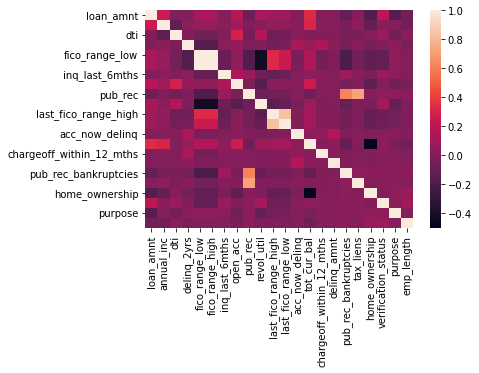

In [9]:
sns.heatmap(use_df.corr())

In [10]:
# last ficon range, fico score의 높은 상관관계를 확인할수 있었다.


### 변수 전처리 및 열연산

In [ ]:
# fico 를 평규내어 열하나로 통합

In [11]:
## fico average column 생성, column drop
use_df["fico_average"] = (use_df["fico_range_high"] + use_df["fico_range_low"])/2
use_df.drop(["fico_range_high", "fico_range_low"], axis=1, inplace=True)
use_df.head()

,loan_amnt,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,last_fico_range_high,last_fico_range_low,...,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,home_ownership,verification_status,purpose,emp_length,fico_average
0,12000,90641.0,10.20,0,1,5,0,0.405,584,580,...,27898,0,0,0,0,6.0,1.0,3.0,2.0,692.0
1,14000,46000.0,17.40,1,0,9,0,0.664,724,720,...,19286,0,0,0,0,6.0,1.0,3.0,2.0,672.0
2,24000,90000.0,11.73,2,0,6,0,0.474,684,680,...,324923,0,0,0,0,2.0,2.0,3.0,6.0,662.0
3,14000,115000.0,7.31,0,1,16,0,0.401,639,635,...,16451,0,0,0,0,6.0,2.0,2.0,5.0,662.0
4,14000,78000.0,24.32,0,2,17,0,0.534,709,705,...,105053,0,0,0,0,6.0,2.0,3.0,4.0,687.0


In [12]:
## logistic regression (ridge, lasso)의 모델을을 돌려야하므로 카테고리 변수에 대해
# 원핫 인코딩 진행

cat_col = ["home_ownership", "verification_status", "purpose"]
use_df = pd.get_dummies(use_df, columns=cat_col, drop_first = True)

In [13]:
## emp_length 변경

length = [[1, 1], [2, 10], [3, 2], [4, 3], [5, 4], [6, 5], [7, 6], [8, 7], [9, 8], [10, 9], [11, 0], [12, -1]]
use_df["new_emp_length"] = np.nan*use_df.shape[0]

for i in length:
    num, value = i[0], i[1]
    use_df.loc[use_df["emp_length"]==num, "new_emp_length"] = value
    # print(num, value)
    # print(use_df["new_emp_length"].value_counts())
    # print("-"*40)

use_df.drop(["emp_length"], axis=1, inplace=True)

In [14]:
use_df.info() # null값 개수 확인

<class 'pandas.core.frame.DataFrame'>
Int64Index: 874335 entries, 0 to 874334
Data columns (total 38 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   loan_amnt                 874335 non-null  int32  
 1   annual_inc                874335 non-null  float64
 2   dti                       874335 non-null  float64
 3   delinq_2yrs               874335 non-null  int8   
 4   inq_last_6mths            874335 non-null  int8   
 5   open_acc                  874335 non-null  int16  
 6   pub_rec                   874335 non-null  int8   
 7   revol_util                874335 non-null  float64
 8   last_fico_range_high      874335 non-null  int16  
 9   last_fico_range_low       874335 non-null  int16  
 10  acc_now_delinq            874335 non-null  int8   
 11  tot_cur_bal               874335 non-null  int32  
 12  chargeoff_within_12_mths  874335 non-null  int8   
 13  delinq_amnt               874335 non-null  i

### 데이터 준비(train, test split)

In [15]:
def train_test(use_df, target_df, test_size=0.2, random_state=2023):
    x_train, x_test, y_train, y_test = train_test_split(use_df, target_df, test_size=test_size, random_state=random_state, stratify=target_df)

    # k-fold 사용해주기 위해서 (x_train, y_train) index 다시 설정
    x_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)

    #test_size 확인
    print(f"test_size: {x_test.shape[0]/use_df.shape[0]*100}%")

    #shape 확인
    print("x_train.shape: ", x_train.shape)
    print("x_test.shape: ", x_test.shape)
    print("y_train.shape: ", y_train.shape)
    print("y_test.shape: ", y_test.shape)

    #train, test 클래스 비율 확인
    print(f"train positive 비율: {pd.Series(y_train).value_counts()[1]/len(pd.Series(y_train))}")
    print(f"test positive 비율: {pd.Series(y_test).value_counts()[1]/len(pd.Series(y_test))}")

    return x_train, x_test, y_train, y_test

In [17]:
## 랜덤시드 고정
np.random.seed(2023)

In [18]:
## 데이터 분포 비율 -> 테스트 0.2 

x_train, x_test, y_train, y_test = train_test(use_df, target_df, test_size=0.2)

test_size: 20.0%
x_train.shape:  (699468, 38)
x_test.shape:  (174867, 38)
y_train.shape:  (699468,)
y_test.shape:  (174867,)
train positive 비율: 0.16204601211206232
test positive 비율: 0.16204887142799956


## Grid Search Pipeline

In [20]:
def run_grid(x_train, y_train, param_grid, fit_params=None, randomstate=2023):
    
    pipe = Pipeline([("preprocessing", None), ("classifier", None)])
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=randomstate)
    grid_search = GridSearchCV(pipe, param_grid, scoring=['roc_auc'], refit="roc_auc", cv=kfold)                                                                                                                       
    grid_search.fit(x_train, y_train)

    # print("BEST score on validation set: {0:,2f}".format(grid_search.best_score_))
    # print("BEST hyperparameters: {}".format(grid_search.best_params_))

    return grid_search

## roc_auc curve drawing function

In [23]:
def new_conf(y, y_pred):
    real_pos_portion = confusion_matrix(y, y_pred)[0]/sum(confusion_matrix(y, y_pred)[0])
    real_neg_portion = confusion_matrix(y, y_pred)[1]/sum(confusion_matrix(y, y_pred)[1])
    return np.array([real_pos_portion, real_neg_portion])

def draw_cfmatrix(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    group_names = ["Fullfill -> Fullfill", "Fullfill -> Charge off", "Charge off -> Fullfill", "Charge off -> Charge off"]
    group_counts = ["count: {0:0.0f}".format(value) for value in cf_matrix.flatten()]

    #여기서 새로운 cf matrix 적용
    cf_matrix = new_conf(y, y_pred)
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    ax.set(xlabel="predict class", ylabel="real class") #원래는 ax였음
    plt.show()

def plot_roc(y, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y, y_pred_proba) # output 3개가 나오는데, 각 threshhold 마다의 fpr, tpr값 인듯
    plt.plot(fpr, tpr, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('test ROC : {}'.format(round(roc_auc_score(y, y_pred_proba),3)),fontsize=16)
    plt.legend()
    plt.show()

def get_clf_eval(y , y_pred, y_pred_proba=None):
    confusion = confusion_matrix( y, y_pred)
    accuracy = accuracy_score(y , y_pred)
    precision = precision_score(y , y_pred)
    recall = recall_score(y , y_pred)
    roc_auc = roc_auc_score(y, y_pred_proba)

    print('오차 행렬')
    draw_cfmatrix(y , y_pred)
    print("ROC Curve")
    plot_roc(y, y_pred_proba)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, roc_auc: {3:.4f}'.format(accuracy , precision ,recall, roc_auc))

## CLassifier 성능 비교

### LAsso

In [21]:
from sklearn.linear_model import Lasso,Ridge

param_grid = {
    'preprocessing': [StandardScaler(), RobustScaler(), MinMaxScaler()],
    'classifier': [Lasso()],
    'classifier__max_iter': [100, 500, 1000],
    'classifier__alpha': [0.1, 0.01, 0.001, 0.0001],
}

best_model = run_grid(x_train, y_train, param_grid)
print(f'best_score: {best_model.best_score_}\n best params : {best_model.best_params_}')

best_score: 0.9233460115335065
 best params : {'classifier': Lasso(alpha=0.001, max_iter=100), 'classifier__alpha': 0.001, 'classifier__max_iter': 100, 'preprocessing': StandardScaler()}


학습된 파라미터로 다시 재학습

In [22]:
sc = StandardScaler()
x_scale = sc.fit_transform(x_train)

model = Lasso(alpha = 0.001,max_iter = 100)
model.fit(x_scale,y_train)

x_test_scale = sc.transform(x_test)
y_pred_proba = model.predict(x_test_scale)
y_pred = np.where(y_pred_proba>=0.5,1,0)

roc_auc curve 그래프 확인 및 다른 지표 확인

오차 행렬


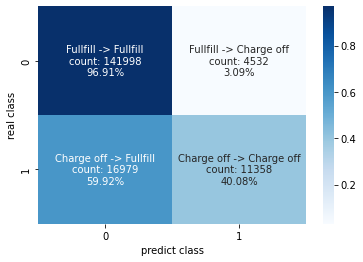

ROC Curve


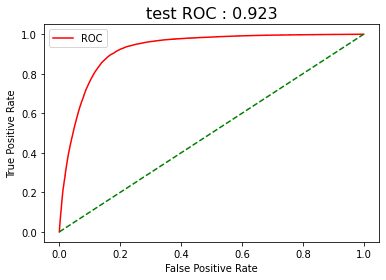

정확도: 0.8770, 정밀도: 0.7148, 재현율: 0.4008, roc_auc: 0.9231


In [24]:
get_clf_eval(y_test , y_pred, y_pred_proba)

coefficient 계수 확인

In [25]:
print('Lasso 모델 계수')
print('-'*30)
for x,y in zip(use_df.columns,model.coef_):
  print(x,f' -> {y:.4f}',)

Lasso 모델 계수
------------------------------
loan_amnt  -> 0.0316
annual_inc  -> -0.0022
dti  -> 0.0144
delinq_2yrs  -> -0.0039
inq_last_6mths  -> 0.0040
open_acc  -> 0.0000
pub_rec  -> 0.0000
revol_util  -> -0.0097
last_fico_range_high  -> -0.1901
last_fico_range_low  -> -0.0380
acc_now_delinq  -> 0.0001
tot_cur_bal  -> -0.0090
chargeoff_within_12_mths  -> 0.0000
delinq_amnt  -> 0.0000
pub_rec_bankruptcies  -> 0.0007
tax_liens  -> -0.0000
fico_average  -> 0.0207
home_ownership_2.0  -> -0.0000
home_ownership_3.0  -> 0.0000
home_ownership_4.0  -> 0.0000
home_ownership_5.0  -> -0.0000
home_ownership_6.0  -> 0.0008
verification_status_2.0  -> 0.0008
verification_status_3.0  -> 0.0039
purpose_2.0  -> 0.0001
purpose_3.0  -> 0.0000
purpose_4.0  -> 0.0000
purpose_5.0  -> -0.0003
purpose_6.0  -> -0.0001
purpose_7.0  -> -0.0000
purpose_8.0  -> 0.0000
purpose_9.0  -> -0.0000
purpose_10.0  -> -0.0008
purpose_11.0  -> -0.0000
purpose_12.0  -> 0.0019
purpose_13.0  -> -0.0000
purpose_14.0  -> -0.0000


### Ridge

In [26]:
from sklearn.linear_model import Lasso,Ridge

param_grid = {
    'preprocessing': [StandardScaler(), RobustScaler(), MinMaxScaler()],
    'classifier': [Ridge()],
    'classifier__max_iter': [300,500,1000],
    'classifier__alpha': [0.1, 0.01, 0.001]
}

best_model = run_grid(x_train, y_train, param_grid)
print(f'best_score: {best_model.best_score_}\n best params : {best_model.best_params_}')

best_score: 0.9233245928501702
 best params : {'classifier': Ridge(alpha=0.1, max_iter=300), 'classifier__alpha': 0.1, 'classifier__max_iter': 300, 'preprocessing': RobustScaler()}


학습된 파라미터로 다시 재학습

In [28]:
sc = RobustScaler()
x_scale = sc.fit_transform(x_train)

model = Ridge(alpha = 0.001,max_iter = 300)
model.fit(x_scale,y_train)

x_test_scale = sc.transform(x_test)
y_pred_proba = model.predict(x_test_scale)
y_pred = np.where(y_pred_proba>=0.5,1,0)

그래프 확인

오차 행렬


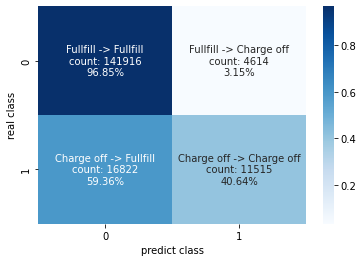

ROC Curve


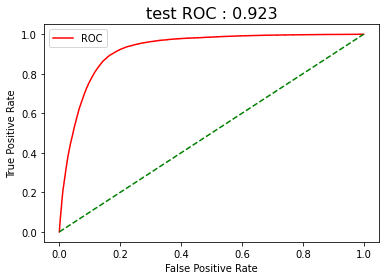

정확도: 0.8774, 정밀도: 0.7139, 재현율: 0.4064, roc_auc: 0.9231


In [29]:
get_clf_eval(y_test , y_pred, y_pred_proba)

계수 확인

In [30]:
print('Ridge 모델 계수')
print('-'*30)
for x,y in zip(use_df.columns,model.coef_):
  print(x,f' -> {y:.4f}',)

Ridge 모델 계수
------------------------------
loan_amnt  -> 0.0461
annual_inc  -> -0.0014
dti  -> 0.0222
delinq_2yrs  -> -0.0051
inq_last_6mths  -> 0.0053
open_acc  -> 0.0004
pub_rec  -> 0.0009
revol_util  -> -0.0157
last_fico_range_high  -> -0.2471
last_fico_range_low  -> -0.0312
acc_now_delinq  -> 0.0155
tot_cur_bal  -> -0.0111
chargeoff_within_12_mths  -> 0.0031
delinq_amnt  -> 0.0000
pub_rec_bankruptcies  -> 0.0040
tax_liens  -> -0.0022
fico_average  -> 0.0295
home_ownership_2.0  -> 0.0071
home_ownership_3.0  -> 0.0704
home_ownership_4.0  -> 0.0394
home_ownership_5.0  -> 0.0063
home_ownership_6.0  -> 0.0098
verification_status_2.0  -> 0.0057
verification_status_3.0  -> 0.0126
purpose_2.0  -> 0.0130
purpose_3.0  -> 0.0111
purpose_4.0  -> 0.1127
purpose_5.0  -> 0.0062
purpose_6.0  -> -0.0077
purpose_7.0  -> 0.0057
purpose_8.0  -> 0.0159
purpose_9.0  -> 0.0045
purpose_10.0  -> 0.0033
purpose_11.0  -> 0.0074
purpose_12.0  -> 0.0383
purpose_13.0  -> 0.0015
purpose_14.0  -> 0.0080
new_emp_l

### ElasticNet

In [31]:
from sklearn.linear_model import ElasticNet

param_grid = {
    'preprocessing': [StandardScaler(), RobustScaler(), MinMaxScaler()],
    'classifier': [ElasticNet()],
    'classifier__max_iter': [100,500,1000],
    'classifier__l1_ratio': [0.2, 0.5],
    'classifier__alpha': [1, 0.01, 0.1]
}

best_model = run_grid(x_train, y_train, param_grid)
print(f'best_score: {best_model.best_score_}\n best params : {best_model.best_params_}')

best_score: 0.9233492177219261
 best params : {'classifier': ElasticNet(alpha=0.01, l1_ratio=0.2, max_iter=100), 'classifier__alpha': 0.01, 'classifier__l1_ratio': 0.2, 'classifier__max_iter': 100, 'preprocessing': StandardScaler()}


베스트 파라미터로 재학습 

In [32]:
sc = StandardScaler()
x_scale = sc.fit_transform(x_train)

model = ElasticNet(alpha = 0.01,max_iter = 100,l1_ratio=0.2)
model.fit(x_scale,y_train)

x_test_scale = sc.transform(x_test)
y_pred_proba = model.predict(x_test_scale)
y_pred = np.where(y_pred_proba>=0.5,1,0)

평가 점수 및 그래프 확인 

오차 행렬


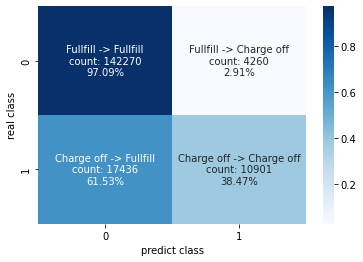

ROC Curve


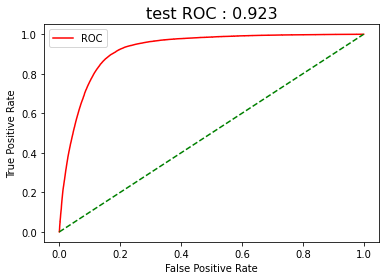

정확도: 0.8759, 정밀도: 0.7190, 재현율: 0.3847, roc_auc: 0.9230


In [33]:
get_clf_eval(y_test , y_pred, y_pred_proba)

계수 확인

In [34]:
print('ElasticNet 모델 계수')
print('-'*30)
for x,y in zip(use_df.columns,model.coef_):
  print(x,f' -> {y:.4f}',)

ElasticNet 모델 계수
------------------------------
loan_amnt  -> 0.0297
annual_inc  -> -0.0013
dti  -> 0.0135
delinq_2yrs  -> -0.0031
inq_last_6mths  -> 0.0032
open_acc  -> 0.0000
pub_rec  -> 0.0000
revol_util  -> -0.0088
last_fico_range_high  -> -0.1848
last_fico_range_low  -> -0.0408
acc_now_delinq  -> 0.0000
tot_cur_bal  -> -0.0082
chargeoff_within_12_mths  -> 0.0000
delinq_amnt  -> 0.0000
pub_rec_bankruptcies  -> 0.0000
tax_liens  -> -0.0000
fico_average  -> 0.0185
home_ownership_2.0  -> -0.0000
home_ownership_3.0  -> 0.0000
home_ownership_4.0  -> 0.0000
home_ownership_5.0  -> -0.0000
home_ownership_6.0  -> 0.0001
verification_status_2.0  -> 0.0000
verification_status_3.0  -> 0.0030
purpose_2.0  -> 0.0000
purpose_3.0  -> 0.0000
purpose_4.0  -> 0.0000
purpose_5.0  -> -0.0000
purpose_6.0  -> -0.0000
purpose_7.0  -> -0.0000
purpose_8.0  -> 0.0000
purpose_9.0  -> -0.0000
purpose_10.0  -> -0.0000
purpose_11.0  -> -0.0000
purpose_12.0  -> 0.0011
purpose_13.0  -> -0.0000
purpose_14.0  -> -0.